In [1]:
import pandas as pd

train_df = pd.read_parquet("flattened_train.parquet")  # or read_csv()
print(train_df.shape)
print(train_df.head())

(458913, 741)
                                         customer_ID  P_2_mean   P_2_max  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...  0.933824  0.960384   
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...  0.899820  0.929122   
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...  0.878454  0.904482   
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  0.598969  0.623392   
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...  0.891679  0.940382   

    P_2_min   P_2_std  D_39_mean  D_39_max  D_39_min  D_39_std  B_1_mean  ...  \
0  0.868580  0.024194   0.010704  0.091505  0.001082  0.024444  0.012007  ...   
1  0.861109  0.022119   0.215205  0.567403  0.002224  0.199150  0.025654  ...   
2  0.797670  0.028911   0.004181  0.009704  0.000802  0.002758  0.004386  ...   
3  0.567442  0.020107   0.048862  0.268476  0.000660  0.088466  0.059876  ...   
4  0.805045  0.042325   0.004644  0.008680  0.000030  0.002882  0.005941  ...   

   D_143_min  D_143_std  D_144_mean  D_144

In [2]:
labels = pd.read_csv("data/train_labels.csv")
train_df = train_df.merge(labels, on="customer_ID", how="inner")

In [3]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.4 MB/s eta 0:00:00a 0:00:01


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import joblib

In [9]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

csv_path = "data/test_data.csv"     # your input CSV
parquet_path = "test_data.parquet"  # desired output file

chunksize = 50000  # adjust based on memory
first_chunk = True
writer = None

for i, chunk in enumerate(pd.read_csv(csv_path, chunksize=chunksize)):
    print(f"Processing chunk {i+1}...")

    # Convert pandas DataFrame to pyarrow Table
    table = pa.Table.from_pandas(chunk)

    # Initialize writer only once
    if first_chunk:
        writer = pq.ParquetWriter(parquet_path, table.schema, compression="snappy")
        first_chunk = False

    # Write each chunk
    writer.write_table(table)

# Close the writer
if writer:
    writer.close()

print(f"✅ Conversion complete! Saved as {parquet_path}")

Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43...
Processing chunk 44.

In [9]:
import pyarrow.parquet as pq
import pandas as pd
import pyarrow as pa
import os, gc

test_path = "test_data.parquet"
output_dir = "test_chunks"
log_file = "progress.log"
batch_size = 2000

os.makedirs(output_dir, exist_ok=True)

reader = pq.ParquetFile(test_path)

# --- Get last processed batch index ---
start_batch = 0
if os.path.exists(log_file):
    with open(log_file, "r") as f:
        start_batch = int(f.read().strip())
    print(f"Resuming from batch {start_batch}")

batches = reader.iter_batches(batch_size=batch_size)

for i, batch in enumerate(batches):

    if i < start_batch:
        continue   # skip completed batches

    print(f"Processing batch {i}")

    df = batch.to_pandas()

    num_cols = df.select_dtypes(include=['float32','float64','int32','int64']).columns.tolist()
    num_cols = [c for c in num_cols if c != "customer_ID"]

    agg_df = df.groupby("customer_ID")[num_cols].agg(['mean','max','min','std'])
    agg_df.columns = [f"{c}_{s}" for c,s in agg_df.columns]
    agg_df = agg_df.reset_index()

    # save batch to separate parquet
    out_file = os.path.join(output_dir, f"batch_{i}.parquet")
    agg_df.to_parquet(out_file)

    # update progress
    with open(log_file, "w") as f:
        f.write(str(i))

    del df, agg_df, batch
    gc.collect()

print("✅ All batch files saved in", output_dir)
print("➡️ Run merge step after completion")

Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing

In [2]:
!pip install polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 8.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 53.6 MB/s eta 0:00:00:00:0100:01


In [4]:
import polars as pl
import glob, os

chunk_dir = "test_chunks"
output_file = "test_merged_temp.parquet"
progress_log = "merge_progress.txt"

# Load list of chunk files
files = sorted(glob.glob(f"{chunk_dir}/*.parquet"))

# Check resume point
start_idx = 0
if os.path.exists(progress_log):
    with open(progress_log, "r") as f:
        start_idx = int(f.read().strip())
    print(f"🔁 Resuming from chunk {start_idx}/{len(files)}")

# If first run, create empty frame
if start_idx == 0 and os.path.exists(output_file):
    os.remove(output_file)

# Process chunks
for i in range(start_idx, len(files)):
    print(f"📦 Merging chunk {i+1}/{len(files)} ➜ {files[i]}")

    df_chunk = pl.read_parquet(files[i])

    if i == 0 or not os.path.exists(output_file):
        df_chunk.write_parquet(output_file)
    else:
        old = pl.read_parquet(output_file)
        merged = pl.concat([old, df_chunk])
        merged.write_parquet(output_file)
    
    # Save progress
    with open(progress_log, "w") as f:
        f.write(str(i+1))

print("✅ All chunks merged. Now aggregating...")

# Final aggregation per customer
df = pl.read_parquet(output_file).lazy().groupby("customer_ID").agg(
    [
        pl.all().exclude("customer_ID").mean(),
        pl.all().exclude("customer_ID").max(),
        pl.all().exclude("customer_ID").min(),
        pl.all().exclude("customer_ID").std(),
    ]
)

df.sink_parquet("test_flat.parquet")

print("🎉 Final file saved as test_flat.parquet")
print("🧹 Cleaning up temporary files...")

os.remove(output_file)
os.remove(progress_log)

print("✅ Done and cleaned!")

🔁 Resuming from chunk 3749/5682
📦 Merging chunk 3750/5682 ➜ test_chunks/batch_4372.parquet


ComputeError: parquet: File out of specification: The file must end with PAR1

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'


In [6]:
import polars as pl
import glob, os

files = sorted(glob.glob("test_chunks/*.parquet"))
output_file = "test_flat.parquet"
progress_log = "merge_progress.txt"

start_idx = 0
if os.path.exists(progress_log):
    with open(progress_log) as f:
        start_idx = int(f.read().strip())
    print(f"⏩ Resuming from chunk {start_idx}")
else:
    print("🚀 Starting fresh")

for i in range(start_idx, len(files)):
    f = files[i]
    print(f"📂 Merging: {f}")
    
    df_chunk = pl.read_parquet(f)

    if os.path.exists(output_file): 
        old = pl.read_parquet(output_file)
        merged = pl.concat([old, df_chunk], how="vertical")
        merged.write_parquet(output_file)
        del old, merged
    else:
        df_chunk.write_parquet(output_file)

    del df_chunk
    
    # ✅ Save checkpoint
    with open(progress_log, "w") as f:
        f.write(str(i + 1))

print("✅ Merge complete!")

⏩ Resuming from chunk 3749
📂 Merging: test_chunks/batch_4372.parquet
📂 Merging: test_chunks/batch_4373.parquet
📂 Merging: test_chunks/batch_4374.parquet
📂 Merging: test_chunks/batch_4375.parquet
📂 Merging: test_chunks/batch_4376.parquet
📂 Merging: test_chunks/batch_4377.parquet
📂 Merging: test_chunks/batch_4378.parquet
📂 Merging: test_chunks/batch_4379.parquet
📂 Merging: test_chunks/batch_438.parquet
📂 Merging: test_chunks/batch_4380.parquet
📂 Merging: test_chunks/batch_4381.parquet
📂 Merging: test_chunks/batch_4382.parquet
📂 Merging: test_chunks/batch_4383.parquet
📂 Merging: test_chunks/batch_4384.parquet
📂 Merging: test_chunks/batch_4385.parquet
📂 Merging: test_chunks/batch_4386.parquet
📂 Merging: test_chunks/batch_4387.parquet
📂 Merging: test_chunks/batch_4388.parquet
📂 Merging: test_chunks/batch_4389.parquet
📂 Merging: test_chunks/batch_439.parquet
📂 Merging: test_chunks/batch_4390.parquet
📂 Merging: test_chunks/batch_4391.parquet
📂 Merging: test_chunks/batch_4392.parquet
📂 Merging

In [3]:
import pandas as pd
import pickle

# Suppose your training data was in train_flat.parquet
train = pd.read_parquet("flattened_train.parquet")

# Save its columns for reference
with open("train_columns.pkl", "wb") as f:
    pickle.dump(train.columns.tolist(), f)

In [1]:
import pandas as pd

train = pd.read_parquet("flattened_train.parquet")
print(train.shape)
train.head()

(458913, 741)


,customer_ID,P_2_mean,P_2_max,P_2_min,P_2_std,D_39_mean,D_39_max,D_39_min,D_39_std,B_1_mean,...,D_143_min,D_143_std,D_144_mean,D_144_max,D_144_min,D_144_std,D_145_mean,D_145_max,D_145_min,D_145_std
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933824,0.960384,0.868580,0.024194,0.010704,0.091505,0.001082,0.024444,0.012007,...,0.000569,0.003564,0.005283,0.009616,0.000610,0.002598,0.005814,0.009827,0.000995,0.003294
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.899820,0.929122,0.861109,0.022119,0.215205,0.567403,0.002224,0.199150,0.025654,...,0.000411,0.003472,0.004218,0.009568,0.000027,0.002871,0.004902,0.009390,0.000796,0.002729
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878454,0.904482,0.797670,0.028911,0.004181,0.009704,0.000802,0.002758,0.004386,...,0.001196,0.002682,0.005113,0.009415,0.000129,0.003638,0.004500,0.006932,0.000443,0.002152
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.598969,0.623392,0.567442,0.020107,0.048862,0.268476,0.000660,0.088466,0.059876,...,0.000615,0.003392,0.004768,0.009919,0.000492,0.002654,0.005236,0.009836,0.000029,0.003406
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.891679,0.940382,0.805045,0.042325,0.004644,0.008680,0.000030,0.002882,0.005941,...,0.000468,0.002268,0.004380,0.009436,0.000633,0.002633,0.004219,0.009666,0.000083,0.003426


In [3]:
train.columns.tolist()

['customer_ID',
 'P_2_mean',
 'P_2_max',
 'P_2_min',
 'P_2_std',
 'D_39_mean',
 'D_39_max',
 'D_39_min',
 'D_39_std',
 'B_1_mean',
 'B_1_max',
 'B_1_min',
 'B_1_std',
 'B_2_mean',
 'B_2_max',
 'B_2_min',
 'B_2_std',
 'R_1_mean',
 'R_1_max',
 'R_1_min',
 'R_1_std',
 'S_3_mean',
 'S_3_max',
 'S_3_min',
 'S_3_std',
 'D_41_mean',
 'D_41_max',
 'D_41_min',
 'D_41_std',
 'B_3_mean',
 'B_3_max',
 'B_3_min',
 'B_3_std',
 'D_42_mean',
 'D_42_max',
 'D_42_min',
 'D_42_std',
 'D_43_mean',
 'D_43_max',
 'D_43_min',
 'D_43_std',
 'D_44_mean',
 'D_44_max',
 'D_44_min',
 'D_44_std',
 'B_4_mean',
 'B_4_max',
 'B_4_min',
 'B_4_std',
 'D_45_mean',
 'D_45_max',
 'D_45_min',
 'D_45_std',
 'B_5_mean',
 'B_5_max',
 'B_5_min',
 'B_5_std',
 'R_2_mean',
 'R_2_max',
 'R_2_min',
 'R_2_std',
 'D_46_mean',
 'D_46_max',
 'D_46_min',
 'D_46_std',
 'D_47_mean',
 'D_47_max',
 'D_47_min',
 'D_47_std',
 'D_48_mean',
 'D_48_max',
 'D_48_min',
 'D_48_std',
 'D_49_mean',
 'D_49_max',
 'D_49_min',
 'D_49_std',
 'B_6_mean',


In [4]:
import pandas as pd

# Load your flattened features
train = pd.read_parquet("flattened_train.parquet")

# Load target labels
labels = pd.read_csv("data/train_labels.csv")  # or .parquet, if that’s the format

# Merge using customer_ID
train = train.merge(labels, on="customer_ID", how="inner")

# Now split features and target
X = train.drop(columns=["customer_ID", "target"])
y = train["target"]

In [5]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.2 MB/s eta 0:00:0000:010:01


In [6]:
import lightgbm as lgb

# Create LightGBM dataset
train_data = lgb.Dataset(X, label=y)

# Set parameters (you can tune later)
params = {
    "objective": "binary",
    "metric": "auc",  # for AMEX or fraud problems
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "verbosity": -1,
    "seed": 42
}

# Train the model
model = lgb.train(params, train_data, num_boost_round=500)

print("✅ Model training completed!")

✅ Model training completed!


In [7]:
# Save model to text format
model.save_model("lgbm_model.txt")
print("✅ Model saved as lgbm_model.txt")

# Also save training columns (important for alignment later)
import pickle
pickle.dump(X.columns.tolist(), open("train_columns.pkl", "wb"))
print("✅ Feature columns saved as train_columns.pkl")

✅ Model saved as lgbm_model.txt
✅ Feature columns saved as train_columns.pkl


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import early_stopping, log_evaluation

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train again on train split
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=500,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(50)
    ]
)

# Evaluate
preds_val = model.predict(X_valid)
roc = roc_auc_score(y_valid, preds_val)
print("Validation ROC-AUC:", roc)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.948732
[100]	valid_0's auc: 0.953088
[150]	valid_0's auc: 0.954858
[200]	valid_0's auc: 0.955715
[250]	valid_0's auc: 0.956091
[300]	valid_0's auc: 0.956269
[350]	valid_0's auc: 0.956324
[400]	valid_0's auc: 0.956356
[450]	valid_0's auc: 0.95641
[500]	valid_0's auc: 0.956471
Did not meet early stopping. Best iteration is:
[489]	valid_0's auc: 0.956473
Validation ROC-AUC: 0.9564726193308007


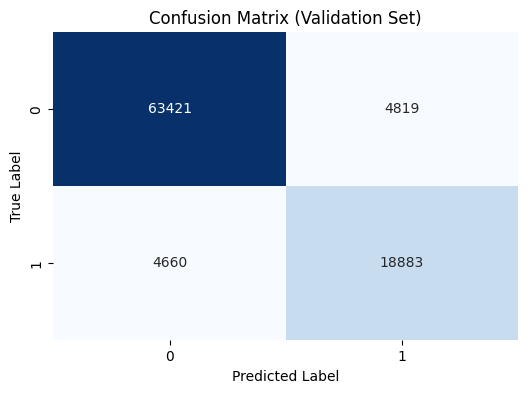


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     68240
           1       0.80      0.80      0.80     23543

    accuracy                           0.90     91783
   macro avg       0.86      0.87      0.86     91783
weighted avg       0.90      0.90      0.90     91783



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Get predictions for validation data
preds_val = model.predict(X_valid)

# Convert probabilities to binary labels (threshold = 0.5)
preds_val_labels = (preds_val >= 0.5).astype(int)

# ✅ Compute confusion matrix
cm = confusion_matrix(y_valid, preds_val_labels)

# ✅ Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ✅ Classification report for more insights
print("\nClassification Report:")
print(classification_report(y_valid, preds_val_labels))